Dataset shape: (569, 30)
Target classes: [0 1]
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Explained Variance by PC1: 44.27%
Explained Variance by PC2: 18.97%
Total Explained Variance: 63.24%


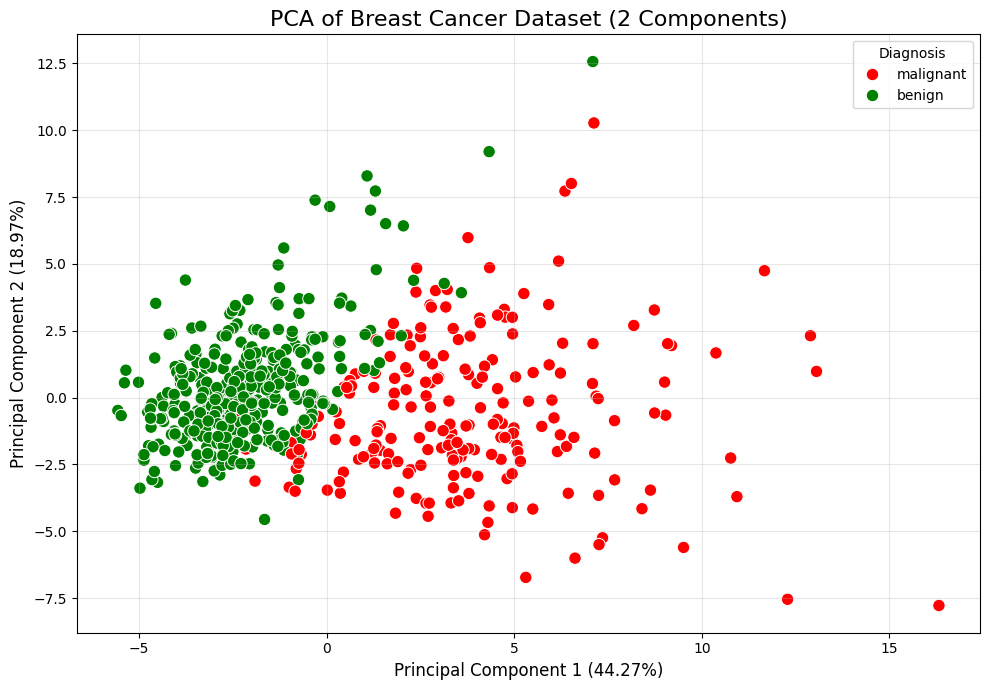


Top 5 Features Contributing to PC1:
mean concave points     0.951490
mean concavity          0.942542
worst concave points    0.915132
mean compactness        0.872817
worst perimeter         0.863167
Name: PC1, dtype: float64

Top 5 Features Contributing to PC2:
mean fractal dimension     0.875292
fractal dimension error    0.668791
worst fractal dimension    0.657443
compactness error          0.555669
smoothness error           0.488130
Name: PC2, dtype: float64

Model Performance Comparison:
Original Model Accuracy (30 features): 98.25%
PCA Model Accuracy (2 components): 94.74%
Variance Retained by PCA: 63.24%



PCA Model Classification Report:
              precision    recall  f1-score   support

   malignant       0.91      0.95      0.93        42
      benign       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



In [2]:
# --- Breast Cancer PCA Analysis ---
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the breast cancer dataset
cancer_data = load_breast_cancer()
X = cancer_data.data
y = cancer_data.target
feature_names = cancer_data.feature_names

print(f"Dataset shape: {X.shape}")
print(f"Target classes: {np.unique(y)}")
print(f"Features: {feature_names}")

# Create DataFrame for exploration
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'Malignant', 1: 'Benign'})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce the dataset to 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create PCA DataFrame to store the PCA components
pca_df = pd.DataFrame(data=principal_components, 
                      columns=['PC1', 'PC2'])
pca_df['Diagnosis'] = cancer_data.target_names[y]

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained Variance by PC2: {explained_variance[1]:.2%}")
print(f"Total Explained Variance: {sum(explained_variance):.2%}")

# Visualize PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Diagnosis', data=pca_df, 
                palette={'malignant': 'red', 'benign': 'green'}, s=80)
plt.title('PCA of Breast Cancer Dataset (2 Components)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%})', fontsize=12)
plt.legend(title='Diagnosis', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_visualization.png', dpi=300)
plt.show()

# Identify important variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=feature_names)

print("\nTop 5 Features Contributing to PC1:")
print(loading_matrix.sort_values('PC1', ascending=False)['PC1'].head(5))

print("\nTop 5 Features Contributing to PC2:")
print(loading_matrix.sort_values('PC2', ascending=False)['PC2'].head(5))

# Optional: Logistic Regression Implementation for prediction
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Original data model (30 features)
original_model = LogisticRegression(max_iter=10000, random_state=42)
original_model.fit(X_train, y_train)
y_pred_original = original_model.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred_original)

# PCA-transformed data (2 components)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

pca_model = LogisticRegression(max_iter=10000, random_state=42)
pca_model.fit(X_train_pca, y_train)
y_pred_pca = pca_model.predict(X_test_pca)
pca_accuracy = accuracy_score(y_test, y_pred_pca)

# Compare results
print("\nModel Performance Comparison:")
print(f"Original Model Accuracy (30 features): {original_accuracy:.2%}")
print(f"PCA Model Accuracy (2 components): {pca_accuracy:.2%}")
print(f"Variance Retained by PCA: {sum(explained_variance):.2%}")

# PCA model confusion matrix
cm = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer_data.target_names,
            yticklabels=cancer_data.target_names)
plt.title('PCA Model Confusion Matrix', fontsize=14)
plt.ylabel('Actual Diagnosis')
plt.xlabel('Predicted Diagnosis')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Classification report
print("\nPCA Model Classification Report:")
print(classification_report(y_test, y_pred_pca, target_names=cancer_data.target_names))

# Visualize decision boundary
def plot_decision_boundary(X, y, model):
    h = .02  # Step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cancer_data.target_names[y],
                    palette={'malignant': 'red', 'benign': 'green'}, s=80)
    plt.title('Logistic Regression Decision Boundary (PCA Components)', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(title='Diagnosis', loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('decision_boundary.png', dpi=300)
    plt.show()

plot_decision_boundary(X_test_pca, y_test, pca_model)